# DeepSpeech Audio Features
In this notebook, I show the results of learning an input to maximize the mean activation of a few specific neurons for every layer of [Mozilla's DeepSpeech model](https://github.com/mozilla/DeepSpeech), and the results of building binary matrices, called _importance masks_, that show which parts of specific inputs to the model contribute to the final classification output.

# Table of Contents
- [Brief Description and Demonstration of Mozilla's DeepSpeech](#Brief-Description-and-Demonstration-of-Mozilla's-DeepSpeech)
- [Description of the DeepSpeech Feature Visualization Problem](#Description-of-the-DeepSpeech-Feature-Visualization-Problem)
    - [Results of doing feature visualization with moderate penalization of total variation](#run_train_inputs_experiment_more_noise)
    - [Results of doing feature visualization with heavier penalization of total variation](#run_train_inputs_experiment)
- [Importance Masks](#Importance-Masks)
    - [Visualizing the importance mask algorithm and applying the masks to MFCCs](#Visualizing-the-importance-mask-algorithm-and-applying-the-masks-to-MFCCs)
    - [Applying the importance masks to audio clips](#Applying-the-importance-masks-to-audio-clips)

In [1]:
%load_ext autoreload
%autoreload 2
from deepspeech_audio_features import *
from IPython.display import Audio, Video, display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
import numpy as np
import os
import soundfile as sf

# Brief Description and Demonstration of Mozilla's DeepSpeech
[DeepSpeech](https://github.com/mozilla/DeepSpeech) is Mozilla's open source speech recognition system based on [Baidu's Deep Speech paper](https://arxiv.org/abs/1412.5567). The input $X$ is a $T \times N$ matrix of [mel-frequency cepstral coefficients (MFCCs)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) where the first dimension is time and the second dimension is MFCC features. The output $y(X)$ is a $T \times K$ matrix of probabilities where $K$ is the amount of symbols in the alphabet. For every time $t \in \left\{1, 2, \ldots, T\right\}$, row $t$ of $y(X)$ is a probability distribution with probabilities for each of the $K$ symbols in the alphabet. So $y(X)_{t, k}$ is the probability that the $k$<sup>th</sup> symbol is being uttered in the $t$<sup>th</sup> time window of the input.

The model has six layers in total: five fully connected layers, and one recurrent layer. The model architecture is described in detail in [this page of the DeepSpeech documentation](https://deepspeech.readthedocs.io/en/latest/DeepSpeech.html) and in [the `create_model` function of `train.py`](https://github.com/mozilla/DeepSpeech/blob/master/training/deepspeech_training/train.py#L162) in the DeepSpeech source code.

In this section, I draw the MFCCs of three example audio files and transcribe them using DeepSpeech.

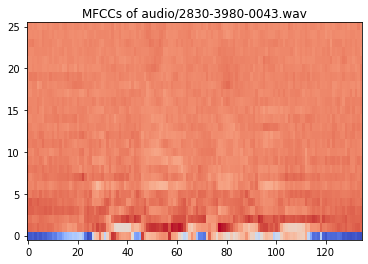

experience proves this


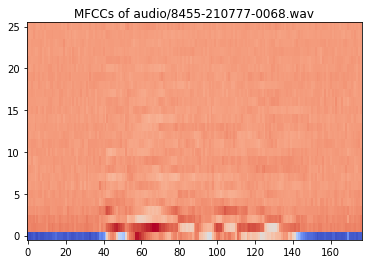

your power is sufficient i said


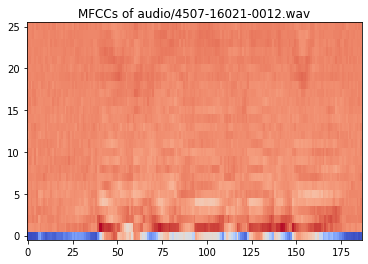

why should one halt on the way


In [2]:
def plot_mfccs(mfccs, title='MFCCs', size=0.1):
    fig, ax = plt.subplots()
    mfccs = np.swapaxes(mfccs, 0, 1)
    cax = ax.imshow(mfccs, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
    ax.set_title(title)
    plt.show()

def show_inferences(paths):
    for path in paths:
        plot_mfccs(audio_file_to_mfccs(path), 'MFCCs of ' + path)
        display(Audio(path))
        tfv1.reset_default_graph()
        do_single_file_inference(path)
    
deepspeech_call(lambda : show_inferences(['audio/2830-3980-0043.wav',
                                          'audio/8455-210777-0068.wav',
                                          'audio/4507-16021-0012.wav']))

# Description of the DeepSpeech Feature Visualization Problem
For the purposes of this project, _feature visualization_ is defined as the problem of maximizing the activation of some part of a model with respect to the input.

Let $y_i(X)$ denote the output of the $i$<sup>th</sup> layer of the DeepSpeech model evaluated on a $T \times N$ input matrix $X$. Then $y_i(X)$ is a $T \times F$ matrix where the first dimension is time and the second dimension is neuron outputs, and the basic feature visualization problem for the $i$<sup>th</sup> layer can be formulated as
\begin{gather}
\underset{X}{\operatorname{arg\,max}}\, \frac{\sum_{t=1}^{T} \sum_{f \in J}^{} \left[y_i(X)\right]_{t,f}}{T \cdot |J|}
\label{basic_problem}
\tag{1}
\end{gather}
where $J \subset \{1, 2, \ldots, F\}$ is the set of the neurons whose combined activation is to be maximized.

Solving problem $\eqref{basic_problem}$ using gradient descent tends to produce a noisy $X$. Some noise can be avoided by adding a regularizer to discourage the [total variation](https://en.wikipedia.org/wiki/Total_variation_denoising#2D_signal_images) of $X$ ([Olah, et al.](https://distill.pub/2017/feature-visualization/)), which is a measure of the similarity between neighboring entries of $X$. The problem then becomes

\begin{gather}
\underset{X}{\operatorname{arg\,max}}\, \frac{\sum_{t=1}^{T} \sum_{f \in J}^{} \left[y_i(X)\right]_{t,f}}{T \cdot |J|}
- \frac{\lambda}{T \cdot N} \sum_{t,n} |X_{t+1,n} - X_{t,n}| + |X_{t,n+1} - X_{t,n}|
\label{full_problem}
\tag{2}
\end{gather}
where $\lambda > 0$ is a hyperparameter that controls to what extent the total variation is penalized.
In this project, experiments are done with two values for $\lambda$ for each of the six layers in the DeepSpeech model.

In [3]:
def map_dir(fn, dir_path, i_init, get_name, inc):
    """Map over the paths of the files in
    the directory specified by dir_path."""
    names = os.listdir(dir_path)
    i = i_init
    values = []
    while True:
        if i < 0:
            break
        name = get_name(i)
        if name not in names:
            break
        values.append(fn(dir_path + '/' + name))
        i += inc
    return values

def get_layer_inputs(dir_path, inc):
    """Load in learned inputs from the disk."""
    n_steps = len(search_dir(dir_path + '/layer_1',
                             lambda path : 'input_var' in path))
    extract_num = lambda s : int(''.join(lfilter(lambda x : x.isdigit(), s)))
    load_inputs = lambda layer_name, name : map_dir(lambda path : (extract_num(path.split('/')[-1]), np.load(path)),
                                                    dir_path + '/' + layer_name,
                                                    (n_steps - 1) * 10,
                                                    lambda i : '%s_%d.npy' % (name, i),
                                                    inc)
    load_layer_inputs = lambda layer_name : lmap(lambda name : load_inputs(layer_name, name),
                                                 ['input_var', 'activation_loss', 'total_var_loss'])
    layer_inputs = lmap(load_layer_inputs, ['layer_1', 'layer_2', 'layer_3',
                                            'rnn_output', 'layer_5', 'layer_6'])
    return layer_inputs

def get_top_examples(n,
                     dir_path='run_search_dataset_experiment',
                     batch_size=128):
    with open('%s/batch_0.pickle' % dir_path, 'rb') as f:
        evaled_loss_dict = pickle.load(f)[0]
        keys = list(set(evaled_loss_dict.keys()) - set(['final_loss']))
        all_losses = {}
        for key in keys:
            all_losses[key] = []
    if n == 0:
        return all_losses
    for i in range(len(search_dir('run_search_dataset_experiment',
                                  lambda path : 'batch' in path))):
        i *= batch_size
        pickle_path = '%s/batch_%d.pickle' % (dir_path, i)
        with open(pickle_path, 'rb') as f:
            evaled_loss_dicts = pickle.load(f)
            for key in all_losses.keys():
                losses = lmap(lambda evaled_loss_dict : evaled_loss_dict[key],
                              evaled_loss_dicts)
                all_losses[key].extend(losses)
    top_examples = {}
    for key in keys:
        activations = -np.asarray(all_losses[key])
        # get the indices of the top n activations
        top_ids = np.argsort(activations)[-n:][::-1]
        with open('run_search_dataset_experiment/all_paths.pickle', 'rb') as f:
            all_paths = pickle.load(f)
        top_examples[key] = list(zip(lmap(lambda i : all_paths[i], top_ids),
                                     activations[top_ids]))
    return top_examples

def show_features(path_dir, inc=-21920, show_trained_inputs=True, num_examples=0, title=''):
    if show_trained_inputs:
        layer_inputs = get_layer_inputs(path_dir, inc)
        num_trained_inputs = len(layer_inputs[0][0])
    else:
        num_trained_inputs = 0
    top_examples = get_top_examples(num_examples)
    keys = ['activation_loss_layer_1', 'activation_loss_layer_2', 'activation_loss_layer_3',
            'activation_loss_rnn_output', 'activation_loss_layer_5', 'activation_loss_layer_6']
    layer_names = [r'$\bf{Layer}$ $\bf{1}$' + '\nneurons 1595, 653, 294',
                   r'$\bf{Layer}$ $\bf{2}$' + '\nneurons 568, 1822, 518',
                   r'$\bf{Layer}$ $\bf{3}$' + '\nneurons 541, 7, 21',
                   r'$\bf{RNN}$ $\bf{output}$' + '\nneurons 857, 882, 679',
                   r'$\bf{Layer}$ $\bf{5}$' + '\nneurons 681, 1184, 1284',
                   r'$\bf{Layer}$ $\bf{6}$' + '\nneurons 6, 17, 28']
    font_size = 5
    m, n = num_trained_inputs + num_examples, 6
    fig, ax = plt.subplots(m, n, dpi=200)
    fig.suptitle(title, fontsize=12, y=1.05)
    for row in range(m):
        for col in range(n):
            if row < num_trained_inputs:
                step = layer_inputs[col][0][row][0]
                mfccs = layer_inputs[col][0][row][1]
                activation = -layer_inputs[col][1][row][1]
                title = 'step %d\nactivation: %.4f' % (step, activation)
            else:
                path, activation = top_examples[keys[col]][row - num_trained_inputs]
                mfccs = audio_file_to_mfccs(path)
                title = '%s\nactivation: %.4f' % (path.split('/')[-1], activation)
            if row == 0:
                title = layer_names[col] + '\n\n' + title
            a = ax[row][col]
            a.imshow(np.swapaxes(mfccs, 0, 1), interpolation='nearest',
                     cmap=cm.coolwarm, origin='lower', aspect='auto')
            a.set_title(title, fontsize=font_size)
            a.tick_params(axis='both', which='major', labelsize=font_size)
            a.tick_params(axis='both', which='minor', labelsize=font_size)
    fig.tight_layout(pad=0.1)
    plt.show()
    
def show_anims(name, title, all_arrays, cmaps, titles=None,
               array_filters=None, n_repeat_last=50, dpi=130,
               *args, **kwargs):
    all_arrays = all_arrays[:]
    for arrays in all_arrays:
        arrays += n_repeat_last * [arrays[-1]]
    n_frames = min(lmap(len, all_arrays))
    num_anims = len(all_arrays)
    if titles is None:
        titles = num_anims * ['']
    if array_filters is None:
        array_filters = num_anims * [lambda array : array]
    fig, ax = plt.subplots(num_anims, 1, dpi=dpi)
    fig.suptitle(title + '\n', fontsize=18)
    if type(ax) != np.ndarray:
        ax = np.asarray([ax])
    imgs = []
    for a, title, array_filter, arrays, cmap in zip(ax, titles, array_filters, all_arrays, cmaps):
        a.set_title(title)
        imgs.append(a.imshow(array_filter(arrays[-1]), interpolation='nearest',
                             cmap=cmap, origin='lower', aspect='auto'))
    fig.tight_layout(pad=0.1)
    def run(i):
        for img, array_filter, arrays in zip(imgs, array_filters, all_arrays):
            img.set_data(array_filter(arrays[i]))
        return []
    ani = animation.FuncAnimation(fig, run, n_frames, blit=True, interval=50)
    path = name + '.mp4'
    ani.save(path)
    plt.close()
    display(Video(path, embed=True, html_attributes='autoplay controls loop'))
    
def show_layer_anims(layer_inputs):
    for li, title, neurons in zip(layer_inputs, ['Layer 1', 'Layer 2', 'Layer 3',
                                                 'RNN output', 'Layer 5', 'Layer 6'],
                                  ['838, 744, 806',
                                   '1569, 1223, 88',
                                   '1479, 1699, 679',
                                   '596, 1080, 266',
                                   '1359, 1234, 13',
                                   '19, 21, 22']):
        arrays = lreversed(lmap(lambda x : x[1], li[0]))
        show_anims(title,
                   'Learned input to maximize\nactivation of neurons ' + neurons + '\nof ' + title + ' as training progresses',
                   [arrays], [cm.coolwarm],
                   array_filters=[lambda array : np.swapaxes(array, 0, 1)],
                   n_repeat_last=10, dpi=80)
        steps = lreversed(lmap(lambda x : x[0], li[0]))
        activations = lreversed(lmap(lambda x : -x[1], li[1]))
        total_vars = lreversed(lmap(lambda x : x[1], li[2]))
        plt.plot(steps, activations, label='Activation')
        plt.plot(steps, total_vars, label='Total variation per pixel')
        plt.title(title)
        plt.xlabel('Optimization step')
        plt.legend()
        plt.show()

<a id='run_train_inputs_experiment_more_noise'></a>
## Moderate penalization of total variation: solving problem [(2)](#Description-of-the-DeepSpeech-Feature-Visualization-Problem) with $\lambda = 1$

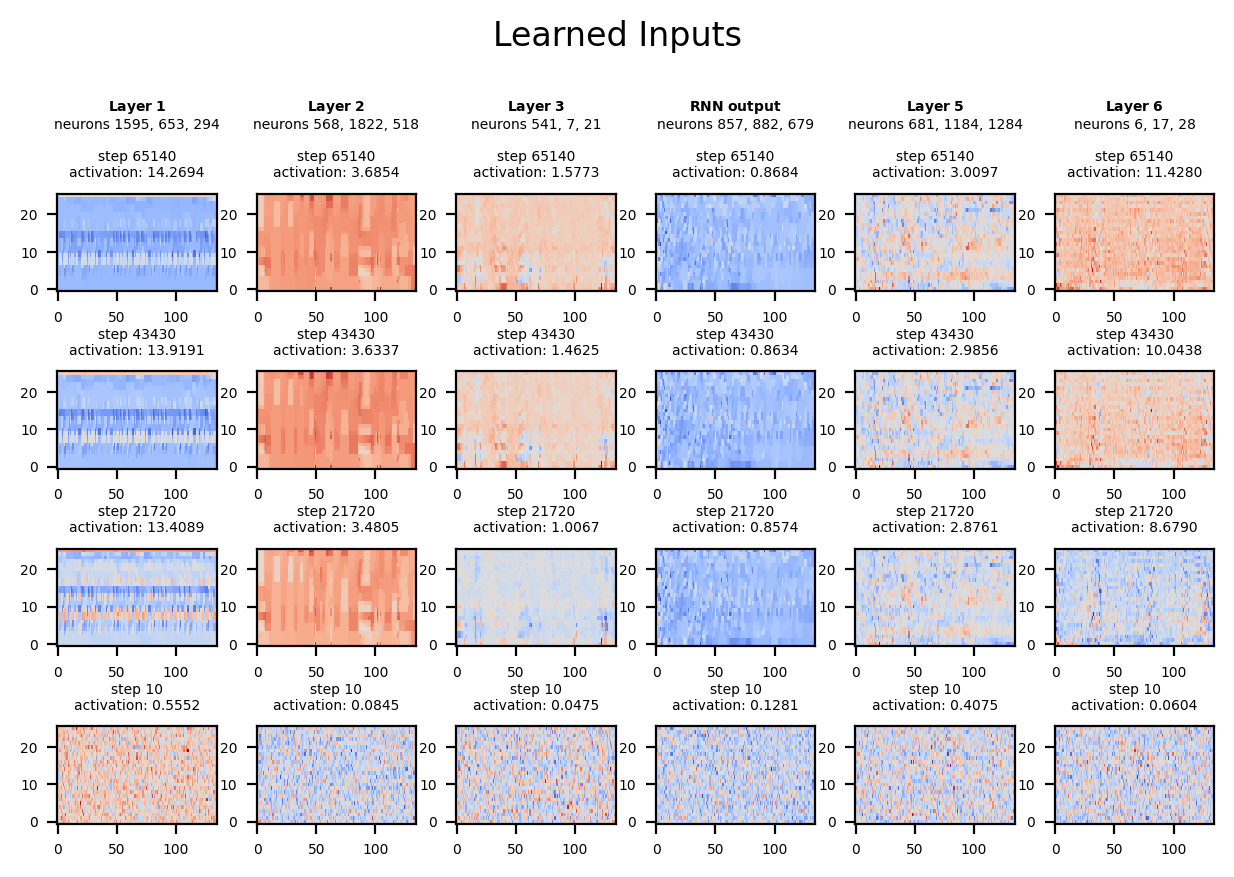

I0830 15:05:17.688055 140488380225216 animation.py:1102] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
I0830 15:05:17.691013 140488380225216 animation.py:346] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 480x320 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'Layer 1.mp4'


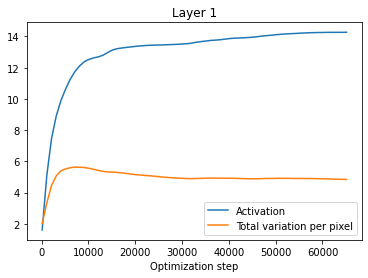

I0830 15:05:24.477656 140488380225216 animation.py:1102] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
I0830 15:05:24.480207 140488380225216 animation.py:346] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 480x320 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'Layer 2.mp4'


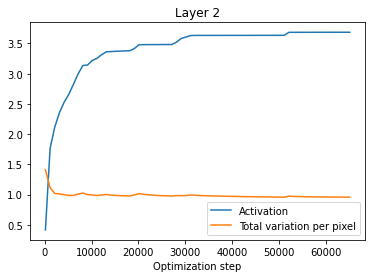

I0830 15:05:31.221870 140488380225216 animation.py:1102] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
I0830 15:05:31.224437 140488380225216 animation.py:346] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 480x320 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'Layer 3.mp4'


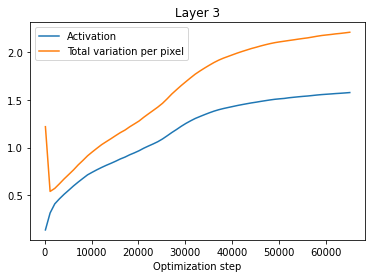

I0830 15:05:38.076468 140488380225216 animation.py:1102] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
I0830 15:05:38.079131 140488380225216 animation.py:346] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 480x320 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'RNN output.mp4'


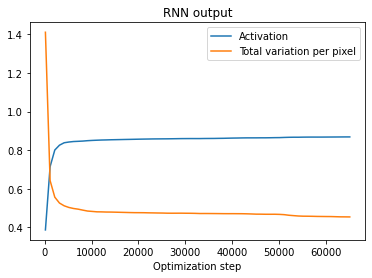

I0830 15:05:44.997744 140488380225216 animation.py:1102] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
I0830 15:05:45.000516 140488380225216 animation.py:346] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 480x320 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'Layer 5.mp4'


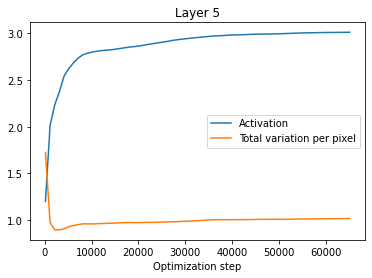

I0830 15:05:51.954865 140488380225216 animation.py:1102] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
I0830 15:05:51.958044 140488380225216 animation.py:346] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 480x320 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'Layer 6.mp4'


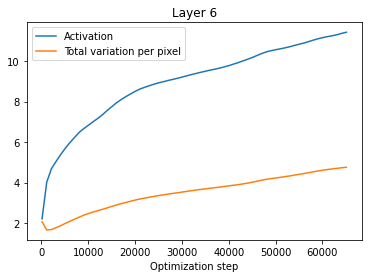

In [4]:
deepspeech_call(lambda : show_features('run_train_inputs_experiment_more_noise',
                                       inc=-21710,
                                       show_trained_inputs=True,
                                       num_examples=0,
                                       title='Learned Inputs'))
show_layer_anims(get_layer_inputs('run_train_inputs_experiment_more_noise', inc=-1000))

<a id='run_train_inputs_experiment'></a>
## Heavier penalization of total variation: solving problem [(2)](#Description-of-the-DeepSpeech-Feature-Visualization-Problem) with $\lambda = 2.808$

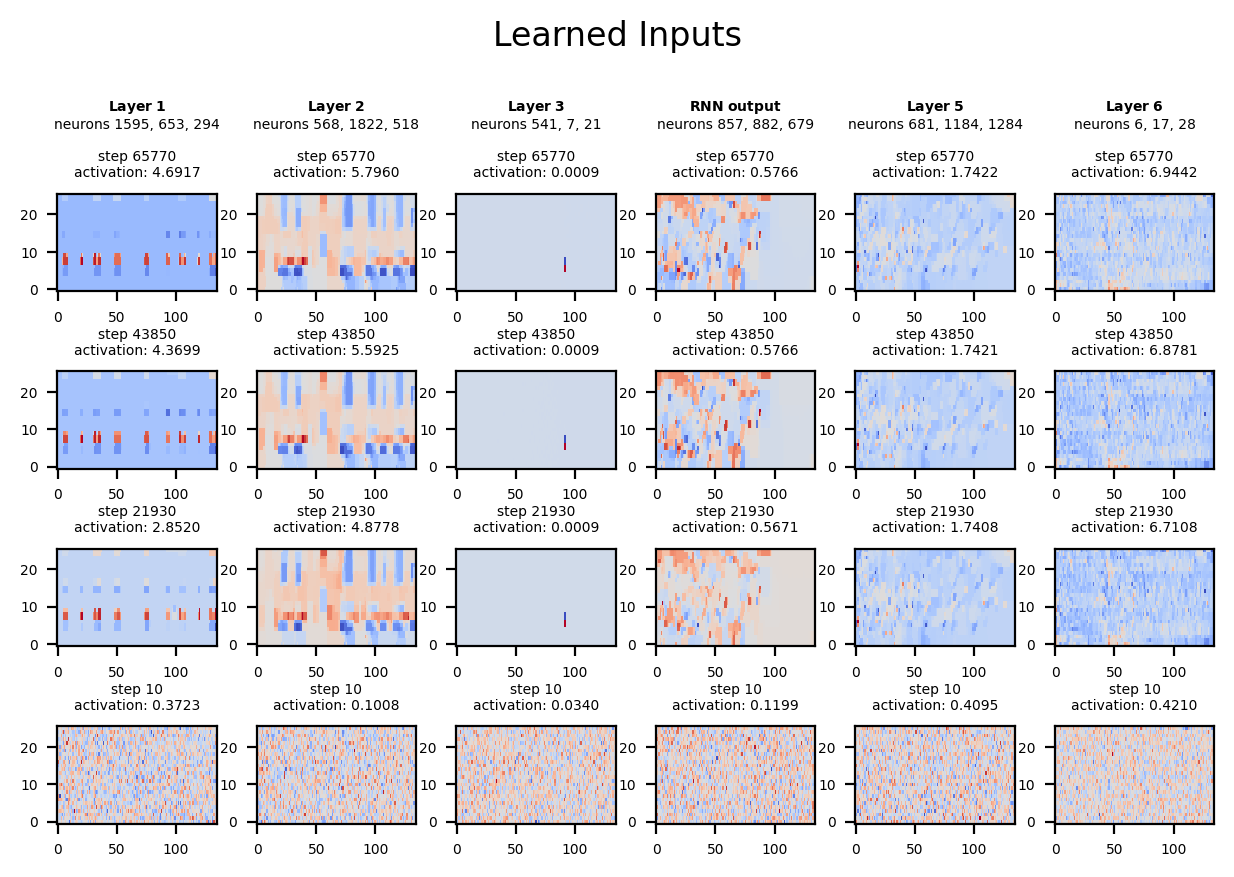

I0830 15:06:17.315719 140488380225216 animation.py:1102] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
I0830 15:06:17.318397 140488380225216 animation.py:346] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 480x320 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'Layer 1.mp4'


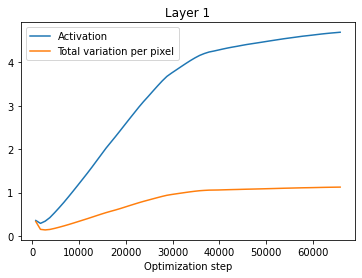

I0830 15:06:24.246381 140488380225216 animation.py:1102] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
I0830 15:06:24.249150 140488380225216 animation.py:346] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 480x320 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'Layer 2.mp4'


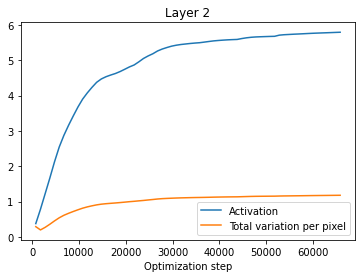

I0830 15:06:31.381159 140488380225216 animation.py:1102] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
I0830 15:06:31.383859 140488380225216 animation.py:346] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 480x320 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'Layer 3.mp4'


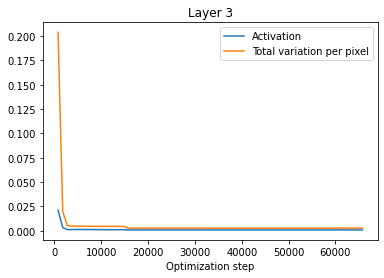

I0830 15:06:38.545928 140488380225216 animation.py:1102] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
I0830 15:06:38.548544 140488380225216 animation.py:346] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 480x320 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'RNN output.mp4'


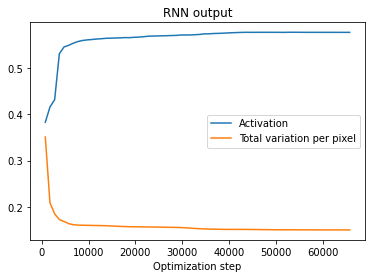

I0830 15:06:45.799929 140488380225216 animation.py:1102] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
I0830 15:06:45.802735 140488380225216 animation.py:346] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 480x320 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'Layer 5.mp4'


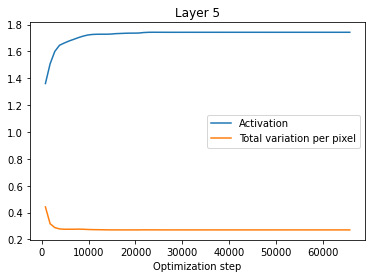

I0830 15:06:53.008870 140488380225216 animation.py:1102] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
I0830 15:06:53.012440 140488380225216 animation.py:346] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 480x320 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'Layer 6.mp4'


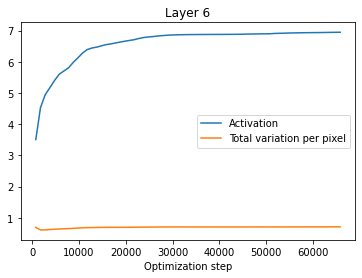

In [5]:
deepspeech_call(lambda : show_features('run_train_inputs_experiment',
                                       show_trained_inputs=True,
                                       num_examples=0,
                                       title='Learned Inputs'))
show_layer_anims(get_layer_inputs('run_train_inputs_experiment', inc=-1000))

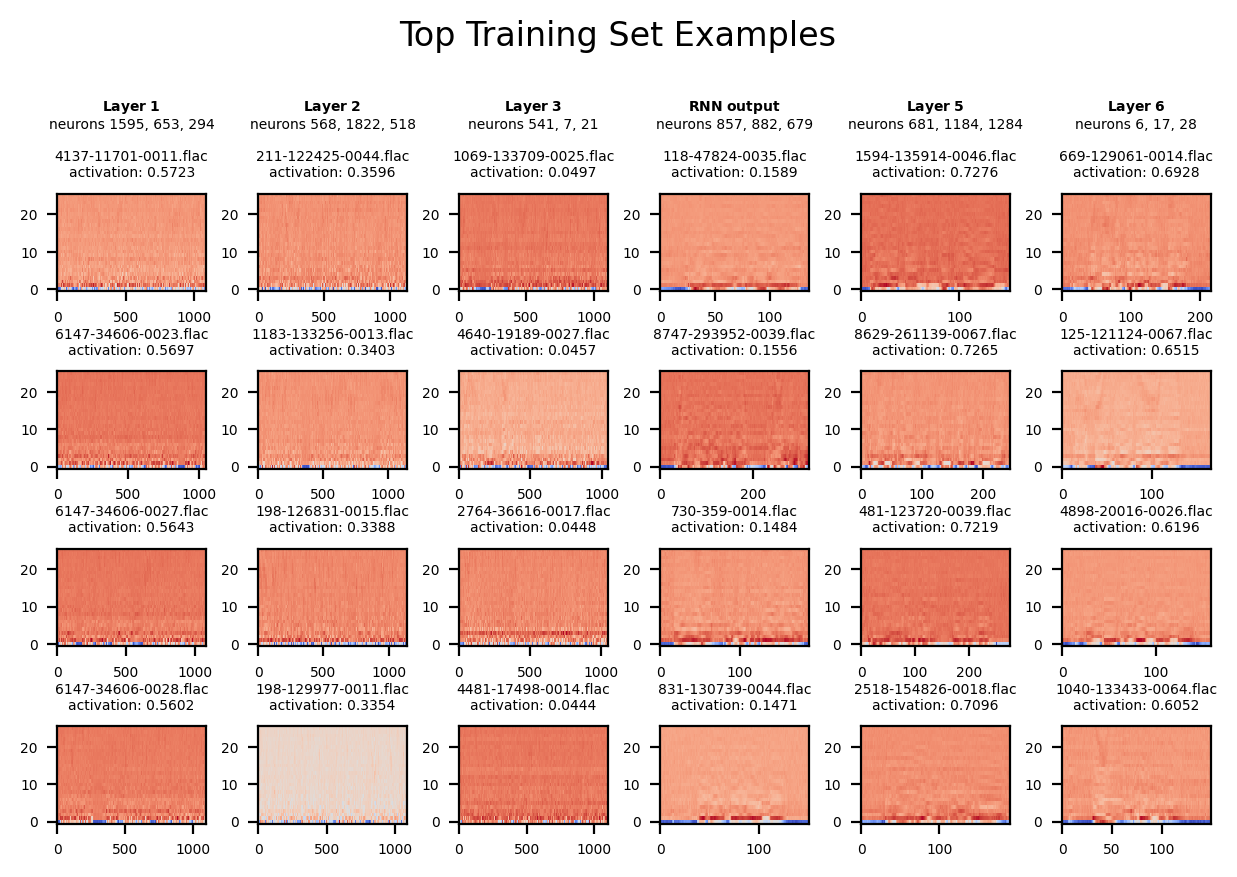

In [6]:
deepspeech_call(lambda : show_features('run_train_inputs_experiment',
                                       show_trained_inputs=False,
                                       num_examples=4,
                                       title='Top Training Set Examples'))

# Importance Masks
Given a $T \times N$ input $X$ to the model, it would be reasonable to ask which entries of $X$ are unimportant, i.e. which entries of $X$ can be set to zero without changing the model's classification output. This section is dedicated to the problem of building a binary matrix $M$ with the same shape as $X$ such that $y(M \odot X)$ gives the same classification as $y(X)$, while as many entries of $M$ as possible are zeros. $M$ is called an _importance mask_.
## Algorithm
Let $f : \text{set of all $T \times K$ matrices} \to \mathbb{Z}^T$
be a function such that

\begin{gather}
f\left(
\begin{bmatrix}
a_{1,1} & a_{1,2} & \cdots & a_{1,K} \\
a_{2,1} & a_{2,2} & \cdots & a_{2,K} \\
\vdots  & \vdots  & \ddots & \vdots  \\
a_{T,1} & a_{T,2} & \cdots & a_{T,K} 
\end{bmatrix}
\right)
=
\begin{bmatrix}
\underset{i}{\operatorname{arg\,max}}\,  a_{1,i} \\
\underset{i}{\operatorname{arg\,max}}\,  a_{2,i} \\
\vdots \\
\underset{i}{\operatorname{arg\,max}}\,  a_{T,i}
\end{bmatrix}
\end{gather}
for all $T \times K$ matrices.

Let $X_\text{input}$ be some input to the model, and let $y(X)$ denote the output of the model for an input $X$.

Let $M$ be a binary matrix with the same shape as $X_\text{input}$.
- Set every entry of $M$ to one.
- In random order, iterate once through the entries of $M$ and for each entry:
    - Set this mask entry to zero.
    - If $f(y(M \odot X_\text{MFCCs})) \neq f(y(X_\text{MFCCs}))$, set this mask entry to one.

## Visualizing the importance mask algorithm and applying the masks to MFCCs

In [7]:
def thin(l, inc=1):
    """Thin a list by skipping elements.."""
    l = lreversed(l)
    thinned = []
    for i in range(0, len(l), inc):
        thinned.append(l[i])
    return lreversed(thinned)
    
def show_mask_anims(masks, path):
    thinned_masks = thin(masks, 100)
    mfccs = audio_file_to_mfccs(path)
    thinned_masked_mfccs = []
    for mask in thinned_masks:
        thinned_masked_mfccs.append(mask * mfccs)
    show_anims(str.replace(path, '/', '-'),
               # 'Binary Importance Mask for\n' + path,
               path,
               [thinned_masks, thinned_masked_mfccs, len(thinned_masks) * [mfccs]],
               [cm.binary, cm.coolwarm, cm.coolwarm],
               ['Binary importance mask\n(black = 0, white = 1)',
                'Binary importance mask multiplied by MFCCs',
                'MFCCs'],
               [lambda array : -np.swapaxes(array, 0, 1),
                lambda array : np.swapaxes(array, 0, 1),
                lambda array : np.swapaxes(array, 0, 1)])
    
dir_paths = ['run_mask_experiment/audio-2830-3980-0043.wav',
             'run_mask_experiment/audio-4507-16021-0012.wav',
             'run_mask_experiment/audio-8455-210777-0068.wav']
all_masks = lmap(lambda dir_path : map_dir(lambda path : np.load(path),
                                           dir_path,
                                           0,
                                           lambda i : '%d.npy' % i, 1),
                 dir_paths)
paths = ['audio/2830-3980-0043.wav',
         'audio/4507-16021-0012.wav',
         'audio/8455-210777-0068.wav']
for masks, path in zip(all_masks, paths):
    deepspeech_call(lambda : show_mask_anims(masks, path))

I0830 15:09:31.416062 140488380225216 animation.py:1102] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
I0830 15:09:31.418797 140488380225216 animation.py:346] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 780x520 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y audio-2830-3980-0043.wav.mp4


I0830 15:09:49.103089 140488380225216 animation.py:1102] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
I0830 15:09:49.106130 140488380225216 animation.py:346] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 780x520 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y audio-4507-16021-0012.wav.mp4


I0830 15:10:10.650785 140488380225216 animation.py:1102] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
I0830 15:10:10.653644 140488380225216 animation.py:346] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 780x520 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y audio-8455-210777-0068.wav.mp4


## Applying the importance masks to audio clips

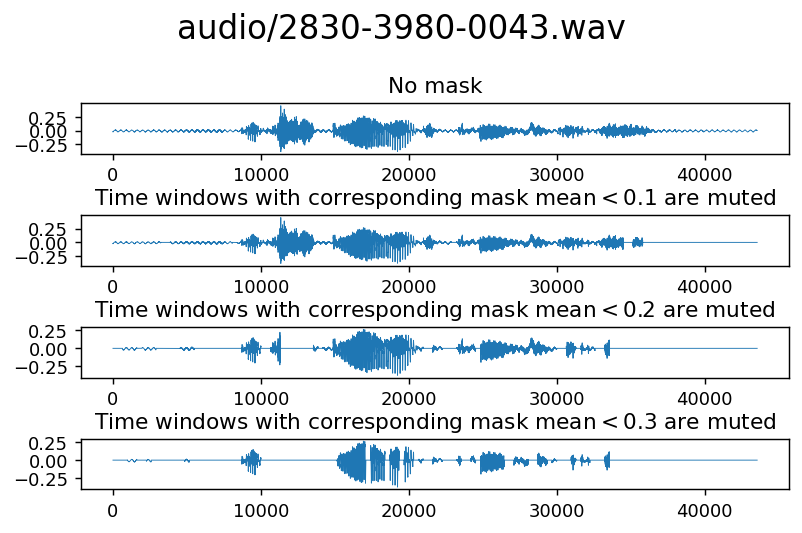

experience proves this


experience proves this


it perience proves t


rn


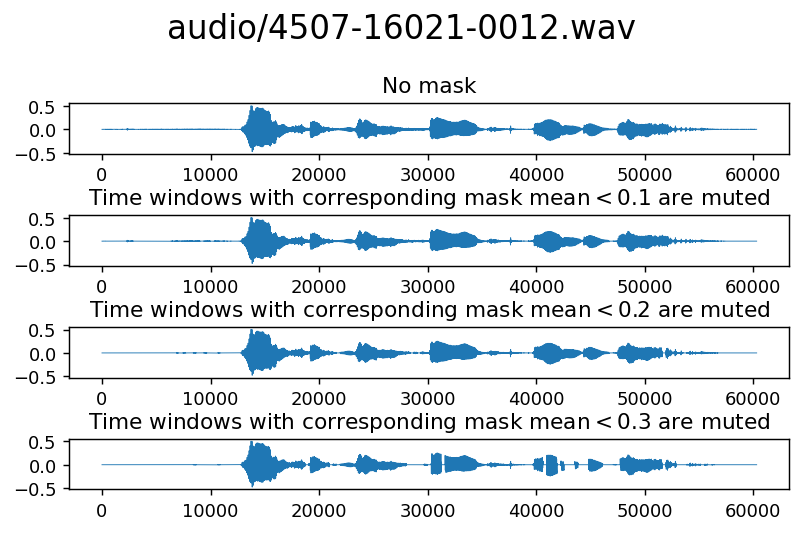

why should one halt on the way


why should one halt on the way


why should one halt on the way


why should one al on po pay


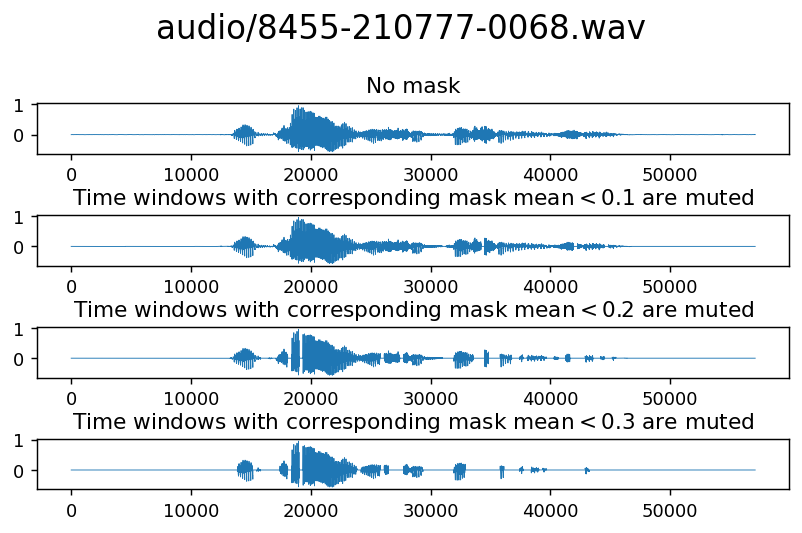

your power is sufficient i said


your power is sufficient i said


your power is suffictentithat


you power it is te


In [8]:
def show_masked_audio(thresholds=[0.1, 0.2, 0.3], lw=0.5):
    for masks, path in zip(all_masks, paths):
        clips = []
        means = np.mean(masks[-1], axis=1)
        y, sr = librosa.load(path)
        clips.append(y)
        width = len(y) / len(means)
        n_plots = len(thresholds)
        fig, ax = plt.subplots(n_plots + 1, 1, dpi=130)
        fig.suptitle(path + '\n', fontsize=18)
        ax[0].set_title('No mask')
        ax[0].plot(y, lw=lw)
        for threshold, a in zip(thresholds, ax[1:]):
            y_masked = np.copy(y)
            for i in range(len(y_masked)):
                if means[int(i // width)] < threshold:
                    y_masked[i] = 0
            clips.append(y_masked)
            a.set_title('Time windows with corresponding mask mean$< %.1f$ are muted' % threshold)
            a.plot(y_masked, lw=lw)
        plt.tight_layout(pad=0.1)
        plt.show()
        for clip in clips:
            display(Audio(clip, rate=sr))
            sf.write('temp.wav', clip, sr)
            tfv1.reset_default_graph()
            do_single_file_inference('temp.wav')

deepspeech_call(show_masked_audio)